# игра в крестики-нолики
* https://github.com/tony20202021/CrossZero
* нейросеть
* обучение:
  * генетический алгоритм (в процессе разработки)
    * застревает в локальных экстремумах
    * надо придумать способ находить глобальный
  * back-propagation
    * Dense (готово)
    * Conv 3*3 (готово)
  * табличный RL
    * model-based
    * model-free
* автоматический подбор (есть реализация на Дельфи, надо перенести в Питон)
  * количества нейронов в скрытом слое
  * количества скрытых слоев
* визуализация ландшафта целевой функции
* TODO
    * RNN/LSTM
    * RL


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')



In [2]:

# import sys
# sys.path.append('/content/drive/MyDrive/CrossZero')

In [3]:
# torch/numpy
random_seed_fix = True


## импорт глобальных библиотек

In [4]:
!pip install -q pytorch-lightning

# опция -q позволяет значительно уменьшить вывод при установке пакета

     |████████████████████████████████| 527 kB 5.4 MB/s 
     |████████████████████████████████| 134 kB 30.8 MB/s 
     |████████████████████████████████| 398 kB 42.2 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 829 kB 40.3 MB/s 
     |████████████████████████████████| 952 kB 40.5 MB/s 
     |████████████████████████████████| 1.1 MB 40.7 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 50.2 MB/s 
     |████████████████████████████████| 271 kB 47.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
from torchsummary import summary

In [6]:
import matplotlib.pyplot as plt

import numpy as np
import random
import os
import collections

import tqdm

In [7]:
import torch
print(torch.__version__)

1.10.0+cu111


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## фиксируем генераторы случайных чисел

In [9]:
if random_seed_fix:
  
  seed = 12345

  random.seed(seed)
  np.random.seed(seed)

  torch.random.manual_seed(seed)

  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.cuda.deterministic = True
  torch.cuda.benchmark = False

In [10]:
torch.cuda.deterministic

True

In [11]:
max_threads = 32

os.environ["OMP_NUM_THREADS"] = str(max_threads)
os.environ["OPENBLAS_NUM_THREADS"] = str(max_threads)
os.environ["MKL_NUM_THREADS"] = str(max_threads)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(max_threads)
os.environ["NUMEXPR_NUM_THREADS"] = str(max_threads)

## импорт локальных библиотек


In [12]:

!wget -O Common.py "https://github.com/tony20202021/CrossZero/raw/main/Python/Common.py"

--2022-03-27 13:12:47--  https://github.com/tony20202021/CrossZero/raw/main/Python/Common.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tony20202021/CrossZero/main/Python/Common.py [following]
--2022-03-27 13:12:48--  https://raw.githubusercontent.com/tony20202021/CrossZero/main/Python/Common.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2266 (2.2K) [text/plain]
Saving to: ‘Common.py’

Common.py           100%[===================>]   2.21K  --.-KB/s    in 0s      

2022-03-27 13:12:48 (27.1 MB/s) - ‘Common.py’ saved [2266/2266]



In [ ]:
from Common import FIGURES_TO_VALUES
from Common import TEMPLATES_WIN

## глобальные константы

In [ ]:
"""
глобальные константы
"""

# scores
SCORES_WEIGHTS = {
    'valid_move': 0,
    'invalid_move': -1e5,
    'win': 100,
    'lose': -1e5,
}

# Net
X_LEN = 3
Y_LEN = 3

# figures
FIGURES = {
  '_X_': '_X_',
  '_0_': '_0_',
  '___': '___',
}
FIGURES_TO_VALUES = {
  '_X_': 1,
  '_0_': -1,
  '___': 0,
}
VALUES_TO_FIGURES = {
  1: '_X_',
  -1: '_0_',
  0: '___',
}

# parties
PARTIES = {
    'random': 10,
}

MAX_MOVES = 5

SCORE_DIGITS = 2


In [ ]:
# templates
TEMPLATES_WIN = np.array([
    [[1, 1, 1],
     [0, 0, 0],
     [0, 0, 0]],
    [[0, 0, 0],
     [1, 1, 1],
     [0, 0, 0]],
    [[0, 0, 0],
     [0, 0, 0],
     [1, 1, 1]],
    [[1, 0, 0],
     [1, 0, 0],
     [1, 0, 0]],
    [[0, 1, 0],
     [0, 1, 0],
     [0, 1, 0]],
    [[0, 0, 1],
     [0, 0, 1],
     [0, 0, 1]],
    [[1, 0, 0],
     [0, 1, 0],
     [0, 0, 1]],
    [[0, 0, 1],
     [0, 1, 0],
     [1, 0, 0]],
])
TEMPLATES_WIN = TEMPLATES_WIN.reshape(TEMPLATES_WIN.shape[0], -1)


# сети через back-propagation

In [ ]:
# cross_zero_net = torch.nn.Sequential(
#           torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3,3), padding=(1,1)),
#           torch.nn.ReLU(),
#           torch.nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3,3), padding=(1,1)),
#           torch.nn.ReLU(),
#           torch.nn.Conv2d(in_channels=20, out_channels=1, kernel_size=(1,1), padding=(0,0)),
#           torch.nn.Sigmoid()
#         )


In [ ]:
class CrossZeroNetConv(torch.nn.Module):
    def __init__(self, mid_channels=1, verbose=False, **kwargs):
        super().__init__()

        self.model = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels=1, out_channels=mid_channels, kernel_size=(3,3), padding=(1,1)),
          torch.nn.ReLU(),
          torch.nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, kernel_size=(3,3), padding=(1,1)),
          torch.nn.ReLU(),
          torch.nn.Conv2d(in_channels=mid_channels, out_channels=1, kernel_size=(1,1), padding=(0,0)),
          torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
        

In [ ]:
class CrossZeroNetDense(torch.nn.Module):
    def __init__(self, n_hidden_neurons=30, verbose=False, **kwargs):
        super().__init__()

        if verbose: print(f"Y_LEN*X_LEN={Y_LEN}*{X_LEN}, n_hidden_neurons={n_hidden_neurons}")
        
        self.model = torch.nn.Sequential(
          torch.nn.Linear(in_features=Y_LEN*X_LEN, out_features=n_hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(in_features=n_hidden_neurons, out_features=Y_LEN*X_LEN),
          torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.reshape(x.shape[0], -1)).reshape(x.shape[0], 1, Y_LEN, X_LEN)
        

In [ ]:
cross_zero_net = CrossZeroNetDense(n_hidden_neurons=30)
cross_zero_net

CrossZeroNetDense(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=9, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
cross_zero_net.to(device)


CrossZeroNetDense(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=9, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
next(cross_zero_net.parameters()).device

device(type='cuda', index=0)

In [ ]:
input = torch.zeros(1, 1, 3,3)
input = input.to(device)
input

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], device='cuda:0')

In [ ]:
input.device

device(type='cuda', index=0)

In [ ]:
# pred = cross_zero_net(input)
pred = cross_zero_net(input)
pred.shape

torch.Size([1, 1, 3, 3])

In [ ]:
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(cross_zero_net.parameters(), 1e-3)

In [ ]:
y_true = torch.zeros(1, 1, 3,3).long()
y_true = y_true.to(device)
y_true.shape

torch.Size([1, 1, 3, 3])

In [ ]:
pred = torch.ones(1, 1, 3,3)
y_true = torch.ones(1, 1, 3,3)
loss(pred, y_true)

tensor(0.)

In [ ]:
pred = cross_zero_net(input)

y_true = torch.zeros(1, 1, 3, 3)

y_true = y_true.to(device)

loss(pred, y_true)

tensor(0.7164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [ ]:
class Scoring():
    """
    проверка линии из одинаковых финур
    """

    @classmethod
    def is_line(cls, board, figure_value, win_len=Y_LEN):
        return any([(abs((template * (board == figure_value)).sum()) >= abs(win_len * figure_value)) for template in TEMPLATES_WIN])


In [ ]:
class Presentation():
    """
    представление хода
    # перевод между человеко-читаемым видом (3*3) и сетью (1*9)
    """

    @staticmethod
    def board_from_human_to_net(board):
        return board.reshape(-1)

    @staticmethod
    def board_from_net_to_human(tensor):
        return tensor.reshape(Y_LEN, X_LEN)

    @staticmethod
    def board_from_net_to_human_str(tensor):
        result = tensor.reshape(Y_LEN, X_LEN)
        result = list(np.vectorize(VALUES_TO_FIGURES.get)(result))
        return result

    @staticmethod
    def move_from_human_to_net(move):
        return move * Y_LEN + X_LEN

    @staticmethod
    def move_from_net_to_human(move):
        if isinstance(move, torch.Tensor):
            move = move.item()
        return (move // Y_LEN, move % Y_LEN)



In [ ]:
def fill_board(board, figure, data):
    if (board == 0).sum() == 0:
        return

    key = str(board)
    if key not in data:
        data[key] = {
            'board': board,
            'figure': figure,
            'presentation': Presentation.board_from_net_to_human_str(board),
            'valid_moves': (board == 0).astype(int),
            'win': set(),
        }
    else:
        if data[key]['figure'] == figure:
            return

    _data_key = data[key]

    for move in range(9):
        if board[move] == 0:
            new_board = board.copy()
            new_board[move] = figure
            new_figure = (((figure + 2) % 3) * 2) - 1

            if Scoring.is_line(new_board, figure, 3):
                if move in data[key]['win']:
                    a=1
                data[key]['win'].add(move)
                continue

            fill_board(new_board, new_figure, data)
    if len(data[key]['win']) == 0:
        data[key]['target'] = data[key]['valid_moves']
    else:
        data[key]['target'] = np.zeros(9)
        data[key]['target'][list(data[key]['win'])] = 1


data = {}

board = np.zeros(9)
fill_board(board, 1, data)

board = np.zeros(9)
fill_board(board, -1, data)

print(len(data))

6617


In [ ]:
data

{'[0. 0. 0. 0. 0. 0. 0. 0. 0.]': {'board': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'figure': 1,
  'presentation': [array(['___', '___', '___'], dtype='<U3'),
   array(['___', '___', '___'], dtype='<U3'),
   array(['___', '___', '___'], dtype='<U3')],
  'target': array([1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'valid_moves': array([1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'win': set()},
 '[1. 0. 0. 0. 0. 0. 0. 0. 0.]': {'board': array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'figure': -1,
  'presentation': [array(['_X_', '___', '___'], dtype='<U3'),
   array(['___', '___', '___'], dtype='<U3'),
   array(['___', '___', '___'], dtype='<U3')],
  'target': array([0, 1, 1, 1, 1, 1, 1, 1, 1]),
  'valid_moves': array([0, 1, 1, 1, 1, 1, 1, 1, 1]),
  'win': set()},
 '[ 1. -1.  0.  0.  0.  0.  0.  0.  0.]': {'board': array([ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'figure': 1,
  'presentation': [array(['_X_', '_0_', '___'], dtype='<U3'),
   array(['___', '___', '___'], dtype='<U3'),
   array(['___', '

In [ ]:
for key in data:
    data[key]['win_list'] = np.zeros(9)
    data[key]['win_list'][list(data[key]['win'])] = 1
# data['[ 1.  0.  1. -1.  0.  1. -1.  0. -1.]']

In [ ]:
data[list(data.keys())[0]]

{'board': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'figure': 1,
 'presentation': [array(['___', '___', '___'], dtype='<U3'),
  array(['___', '___', '___'], dtype='<U3'),
  array(['___', '___', '___'], dtype='<U3')],
 'target': array([1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'valid_moves': array([1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'win': set(),
 'win_list': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [ ]:
X_train = torch.Tensor([data[key]['board'] for key in data])
y_train = torch.Tensor([data[key]['valid_moves'] for key in data])

X_train = X_train.reshape(X_train.shape[0], 1, Y_LEN, X_LEN)
y_train = y_train.reshape(y_train.shape[0], 1, Y_LEN, X_LEN)
 
X_test = X_train
y_test = y_train

X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

(torch.Size([6617, 1, 3, 3]),
 torch.Size([6617, 1, 3, 3]),
 torch.Size([6617, 1, 3, 3]),
 torch.Size([6617, 1, 3, 3]))

In [ ]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

## конфигурации

In [ ]:
# model_class = CrossZeroNetConv
model_class = CrossZeroNetDense

mid_channels = 30
n_hidden_neurons = 30

verbose = True

loss_class = torch.nn.BCELoss
# optimizer = torch.optim.Adam(cross_zero_net.parameters(), 1e-3)

learning_rate = 1e-3

optimizers_all = {
    'Adam':{},
  }

for optimizer_key in optimizers_all:
  optimizers_all[optimizer_key]['model'] = model_class(mid_channels=mid_channels, n_hidden_neurons=n_hidden_neurons, verbose=verbose).to(device)

  optimizers_all[optimizer_key]['loss_train'] = loss_class()
  optimizers_all[optimizer_key]['loss_test'] = loss_class()
  optimizers_all[optimizer_key]['train_accuracy_history'] = []
  optimizers_all[optimizer_key]['train_loss_history'] = []
  optimizers_all[optimizer_key]['test_accuracy_history'] = []
  optimizers_all[optimizer_key]['test_loss_history'] = []

optimizers_all['Adam']['optimizer'] = torch.optim.Adam(optimizers_all
  ['Adam']['model'].parameters(), lr=learning_rate)

print(len(optimizers_all))

Y_LEN*X_LEN=3*3, n_hidden_neurons=30
1


In [ ]:
verbose = True
 
mid_channels_all = {
    10:{},
    20:{},
    30:{},
    40:{},
  }

model_class = CrossZeroNetConv
n_hidden_neurons = None
# mid_channels = 1

loss_class = torch.nn.BCELoss

learning_rate = 1e-3

for mid_channels in mid_channels_all:
  mid_channels_all[mid_channels]['model'] = model_class(n_hidden_neurons=n_hidden_neurons, mid_channels=mid_channels, verbose=verbose).to(device)
  mid_channels_all[mid_channels]['loss_train'] = loss_class()
  mid_channels_all[mid_channels]['loss_test'] = loss_class()
  mid_channels_all[mid_channels]['train_accuracy_history'] = []
  mid_channels_all[mid_channels]['train_loss_history'] = []
  mid_channels_all[mid_channels]['test_accuracy_history'] = []
  mid_channels_all[mid_channels]['test_loss_history'] = []

  mid_channels_all[mid_channels]['optimizer'] = torch.optim.Adam(mid_channels_all[mid_channels]['model'].parameters(), lr=learning_rate)

print(len(mid_channels_all))

4


In [ ]:
verbose = True
 
n_hidden_neurons_all = {
    40:{},
    50:{},
    60:{},
  }

model_class = CrossZeroNetDense

loss_class = torch.nn.BCELoss

learning_rate = 1e-3

for n_hidden_neurons in n_hidden_neurons_all:
  n_hidden_neurons_all[n_hidden_neurons]['model'] = model_class(n_hidden_neurons=n_hidden_neurons, verbose=verbose).to(device)
  n_hidden_neurons_all[n_hidden_neurons]['loss_train'] = loss_class()
  n_hidden_neurons_all[n_hidden_neurons]['loss_test'] = loss_class()
  n_hidden_neurons_all[n_hidden_neurons]['train_accuracy_history'] = []
  n_hidden_neurons_all[n_hidden_neurons]['train_loss_history'] = []
  n_hidden_neurons_all[n_hidden_neurons]['test_accuracy_history'] = []
  n_hidden_neurons_all[n_hidden_neurons]['test_loss_history'] = []

  n_hidden_neurons_all[n_hidden_neurons]['optimizer'] = torch.optim.Adam(n_hidden_neurons_all[n_hidden_neurons]['model'].parameters(), lr=learning_rate)

print(len(n_hidden_neurons_all))

Y_LEN*X_LEN=3*3, n_hidden_neurons=40
Y_LEN*X_LEN=3*3, n_hidden_neurons=50
Y_LEN*X_LEN=3*3, n_hidden_neurons=60
3


## utils

In [ ]:
from IPython.display import clear_output
import tqdm


def train_model(configuration, X_train, y_train, X_test, y_test, suptitle, n_epochs=100, n_epochs_plot=10):
    num_train_samples = X_train.shape[0]

    # batch_size = 2
    batch_size = num_train_samples

    # print(X_train)

    for epoch_index in tqdm.tqdm(range(n_epochs)):
        # order = np.random.permutation(num_train_samples)
        # # print(order)

        # X_train = X_train[order]
        # y_train = y_train[order]
        # # print(X_train)

        for batch_start in range(0, num_train_samples, batch_size):
            X_batch = X_train[batch_start: batch_start + batch_size].to(device)
            y_batch = y_train[batch_start: batch_start + batch_size].to(device)
            if (len(X_batch) != batch_size) or (len(y_batch) != batch_size):
                print(batch_start, batch_start + batch_size, batch_size, len(X_batch), len(y_batch))

            # print(X_batch.shape, y_batch.shape)
            for configuration_key in configuration:

                configuration[configuration_key]['model'].train()

                pred = configuration[configuration_key]['model'](X_batch)
                # print(pred.shape, y_batch.shape)

                assert(pred.shape == y_batch.shape)

                predicted_argmax = pred.reshape(pred.shape[0], -1).argmax(1)
                assert(predicted_argmax.shape[0] == pred.shape[0])

                predicted_compare = torch.gather(y_batch.reshape(y_batch.shape[0], -1), 1, predicted_argmax.unsqueeze(1))
                assert(predicted_compare.shape[0] == predicted_argmax.shape[0])

                correct_train = ((predicted_compare == 1).sum() / len(y_batch)).detach()
                assert(correct_train >= 0.0)
                assert(correct_train <= 1.0)

                loss_val = configuration[configuration_key]['loss_train'](pred, y_batch)
                loss_val.backward()

                configuration[configuration_key]['optimizer'].step()
                configuration[configuration_key]['optimizer'].zero_grad()

                if batch_start == 0:
                    configuration[configuration_key]['train_loss_history'].append(loss_val.detach())
                    configuration[configuration_key]['train_accuracy_history'].append(correct_train)

                    # configuration[configuration_key]['model'].eval()
                    # with torch.no_grad():
                    #     test_preds = configuration[configuration_key]['model'](X_test.to(device))
                    #
                    #     assert (test_preds.shape == y_test.shape)
                    #
                    #     predicted_argmax = test_preds.reshape(test_preds.shape[0], -1).argmax(1)
                    #     assert (predicted_argmax.shape[0] == test_preds.shape[0])
                    #
                    #     correct = ((y_test.reshape(y_test.shape[0], -1)[:, predicted_argmax eryreyery] == 1).sum() / len(y_test)).detach()
                    #     assert (correct >= 0.0)
                    #     assert (correct <= 1.0)
                    #
                    #     # print(predicted.shape, y_test.shape)
                    #
                    #     loss_test_val = configuration[configuration_key]['loss_test'](test_preds, y_test.to(device))
                    #     configuration[configuration_key]['test_loss_history'].append(loss_test_val.detach())
                    #     configuration[configuration_key]['test_accuracy_history'].append(correct)

        if (epoch_index % n_epochs_plot) == 0:
            clear_output(True)

            fig, ax = plt.subplots(len(configuration), 2, figsize=(29, 3 * len(configuration)))
            ax = ax.reshape(len(configuration), -1)

            fig.subplots_adjust(hspace=.5)
            fig.suptitle(suptitle, fontsize=20)

            for optimizer_index, configuration_key in enumerate(configuration):
                ax[optimizer_index, 0].set_title(configuration_key)
                ax[optimizer_index, 0].set_xlabel('epochs')
                ax[optimizer_index, 0].set_ylabel('loss')
                ax[optimizer_index, 0].plot(configuration[configuration_key]['train_loss_history'], label=f"train last={np.array(configuration[configuration_key]['train_loss_history'])[-1]:.3f}")
                # ax[optimizer_index, 0].plot(configuration[configuration_key]['test_loss_history'], label=f"test")
                ax[optimizer_index, 0].legend()
                ax[optimizer_index, 0].grid(True)

                ax[optimizer_index, 1].set_title(configuration_key)
                ax[optimizer_index, 1].set_xlabel('epochs')
                ax[optimizer_index, 1].set_ylabel('accuracy')
                ax[optimizer_index, 1].plot(configuration[configuration_key]['train_accuracy_history'],
                                            label=f"train: last={np.array(configuration[configuration_key]['train_accuracy_history'])[-1]:.3f} ")
                # ax[optimizer_index, 1].plot(configuration[configuration_key]['test_accuracy_history'],
                #                             label=f"test: {np.array(configuration[configuration_key]['test_accuracy_history']).max():.3f} ({np.array(configuration[configuration_key]['test_accuracy_history']).argmax()})")
                ax[optimizer_index, 1].legend()
                ax[optimizer_index, 1].grid(True)

            plt.show()



In [ ]:
def eval_model(model, loss_function, X_test, y_test, verbose=False):
    if verbose: print(f"X_test:{X_test.shape}")
    X_test_reshape = X_test.reshape(X_test.shape[0], -1)
    if verbose: print(f"X_test_reshape:{X_test_reshape.shape}")
    pred = model(X_test_reshape)
    if verbose: print(f"pred:{pred.shape}")
    pred = pred.reshape(pred.shape[0], 1, Y_LEN, X_LEN)
    if verbose: print(f"pred:{pred.shape}, {type(pred)}, {pred.dtype}")
    assert(pred.shape == y_test.shape)

    if verbose: print(f"y_test:{y_test.shape}, {type(y_test)}, {y_test.dtype}")
    loss_val = loss_function(pred, y_test).detach()

    predicted_argmax = pred.reshape(pred.shape[0], -1).argmax(1)
    assert(predicted_argmax.shape[0] == pred.shape[0])
    predicted_compare = torch.gather(y_test.reshape(y_test.shape[0], -1), 1, predicted_argmax.unsqueeze(1))
    assert(predicted_compare.shape[0] == predicted_argmax.shape[0])
    correct_train = ((predicted_compare == 1).sum() / len(y_test)).detach()
    assert(correct_train >= 0.0)
    assert(correct_train <= 1.0)

    return loss_val, correct_train

In [ ]:
def print_parameters(title, parameters):
    print('-'*40)
    print(title)
    for p in list(parameters):
        print(f"{p.shape} \n\t min:{p.min().item()} \n\t max:{p.max().item()} \n\t mean:{p.mean().item()} \n\t var:{p.var().item()}")
    print('-'*40)

def generate_parameters(model, alpha=1.0):
    old_parameters = model.parameters(recurse=True)
    new_parameters = []
    for param in old_parameters:
        new_parameters.append(param.data * (1 + alpha * torch.randn(*param.data.shape).to(param.data.device)))    
    return new_parameters

def set_parameters(old_parameters, new_parameters):
    for old_param, new_param in zip(old_parameters, new_parameters):
        old_param.data = new_param.data


verbose = True

if verbose:
    model = CrossZeroNetDense(n_hidden_neurons=30)

    print_parameters('old_parameters', model.parameters(recurse=True))

    new_parameters = generate_parameters(model, alpha=0.0)

    print_parameters('new_parameters', new_parameters)

    set_parameters(model.parameters(recurse=True), new_parameters)

    print_parameters('new_model', model.parameters(recurse=True))

----------------------------------------
old_parameters
torch.Size([30, 9]) 
	 min:-0.3318720757961273 
	 max:0.3331722021102905 
	 mean:0.019208509474992752 
	 var:0.03653520345687866
torch.Size([30]) 
	 min:-0.277288556098938 
	 max:0.2984273433685303 
	 mean:0.006915565114468336 
	 var:0.030857477337121964
torch.Size([9, 30]) 
	 min:-0.18219426274299622 
	 max:0.17873439192771912 
	 mean:-0.013018426485359669 
	 var:0.009927372448146343
torch.Size([9]) 
	 min:-0.16266193985939026 
	 max:0.13433603942394257 
	 mean:-0.02670452930033207 
	 var:0.012746209278702736
----------------------------------------
----------------------------------------
new_parameters
torch.Size([30, 9]) 
	 min:-0.3318720757961273 
	 max:0.3331722021102905 
	 mean:0.019208509474992752 
	 var:0.03653520345687866
torch.Size([30]) 
	 min:-0.277288556098938 
	 max:0.2984273433685303 
	 mean:0.006915565114468336 
	 var:0.030857477337121964
torch.Size([9, 30]) 
	 min:-0.18219426274299622 
	 max:0.17873439192771912 


In [ ]:
import copy 

def generate_random_direction(model):
    old_parameters = model.parameters(recurse=True)
    list_of_weights = []
    for weight in old_parameters:
        list_of_weights.append(weight*(1 + torch.randn(*weight.shape).to(weight.data.device)))
    return list_of_weights

def generate_surface(model_original, loss_function, bound=10, n_grid=10, verbose=False):
    model = copy.deepcopy(model_original)

    alphas  = np.linspace(-bound, bound, n_grid)
    betas   = np.linspace(-bound, bound, n_grid)
    
    v_1     = generate_random_direction(model)
    v_2     = generate_random_direction(model)

    losses  = np.zeros((len(alphas), len(betas)))
    accuraces  = np.zeros((len(alphas), len(betas)))

    print(f"bound: {-bound}..{bound}")
    print(f"grid: {n_grid*n_grid} ({n_grid}*{n_grid})")
    print(f"alphas: {len(alphas)}")

    for i_alpha, alpha in tqdm.tqdm(enumerate(alphas)):
        # for i_beta, beta in tqdm.tqdm(enumerate(betas), leave=False):
        for i_beta, beta in enumerate(betas):
            # if verbose: print(f"alphas,betas[{i_alpha},{i_beta}]=({alpha},{beta})")

            new_weights = []
            old_parameters = model_original.parameters(recurse=True)
            for weight, v_1_weight, v_2_weight in zip(old_parameters, v_1, v_2):
                new_weight = weight + alpha*v_1_weight + beta*v_2_weight
                new_weights.append(new_weight)

            set_parameters(model.parameters(recurse=True), new_weights)

            # if (alpha == 0) and (beta == 0):
            #     print_parameters('model_original', model_original.parameters(recurse=True))
            #     print_parameters('new_model', model.parameters(recurse=True))
            
            if verbose: print(f"X_test:{X_test.shape}")
            X_test_reshape = X_test.reshape(X_test.shape[0], -1)
            if verbose: print(f"X_test_reshape:{X_test_reshape.shape}")
    
            pred = model(X_test_reshape)
            if verbose: print(f"pred:{pred.shape}")
            pred = pred.reshape(pred.shape[0], 1, Y_LEN, X_LEN)
            if verbose: print(f"pred:{pred.shape}, {type(pred)}, {pred.dtype}")
            assert(pred.shape == y_test.shape)

            loss_val = loss_function(pred, y_test).detach()

            predicted_argmax = pred.reshape(pred.shape[0], -1).argmax(1)
            assert(predicted_argmax.shape[0] == pred.shape[0])
            predicted_compare = torch.gather(y_test.reshape(y_test.shape[0], -1), 1, predicted_argmax.unsqueeze(1))
            assert(predicted_compare.shape[0] == predicted_argmax.shape[0])
            accuracy_val = ((predicted_compare == 1).sum() / len(y_test)).detach()
            assert(accuracy_val >= 0.0)
            assert(accuracy_val <= 1.0)

            if verbose: print(f"alphas,betas[{i_alpha},{i_beta}]=({alpha},{beta}), loss={loss_val}, accuracy={accuracy_val}")
            if verbose: print(np.min([torch.min(p_old == p_new) for p_old, p_new in zip(model_original.parameters(recurse=True), model.parameters(recurse=True))]))
            # if (alpha == 0) and (beta == 0):
            #     for p_old, p_new in zip(model_original.parameters(recurse=True), model.parameters(recurse=True)):
            #         if not torch.min(p_old == p_new):
            #             for axis_0_old, axis_0_new in zip(p_old, p_new):                    
            #                 print(axis_0_old.shape, axis_0_new.shape)
            #                 print(axis_0_old == axis_0_new)
            #                 print(axis_0_old)
            #                 print(axis_0_new)

            losses[i_alpha, i_beta] = loss_val.detach()
            accuraces[i_alpha, i_beta] = accuracy_val.detach()
        
    return alphas, betas, losses, accuraces


In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def plot_surface(alphas, betas, result, title='test...1...2...3...'):
    z_data = result
    z = result
    sh_0, sh_1 = z.shape
    x, y = alphas, betas
    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
    fig.update_layout(title=title, 
                      autosize=False, width=800, height=800,
                      margin=dict(l=65, r=50, b=65, t=90)
                      )
    fig.show()

In [ ]:
def calc_and_show_surface(model, loss_function, bound=1, n_grid=10, verbose=False):
    alphas, betas, losses, accuraces = generate_surface(model_original=model, loss_function=loss_function, bound=bound, n_grid=n_grid, verbose=verbose)

    plot_surface(alphas=alphas, betas=betas, result=losses)
    plot_surface(alphas=alphas, betas=betas, result=accuraces)


## обучение

In [ ]:
optimizers_all['Adam']['model']


CrossZeroNetDense(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=9, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
model = optimizers_all['Adam']['model']

input_shape = X_train.shape

summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]             300
              ReLU-2                   [-1, 30]               0
            Linear-3                    [-1, 9]             279
           Sigmoid-4                    [-1, 9]               0
Total params: 579
Trainable params: 579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.23
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


In [ ]:
# рандомизируем веса

configuration = optimizers_all
configuration_key = 'Adam'

model = configuration[configuration_key]['model']

new_parameters = generate_parameters(model, alpha=1.0)
set_parameters(model.parameters(recurse=True), new_parameters)

configuration[configuration_key]['model'] = model

loss_function = configuration[configuration_key]['loss_train']
loss_val, correct_train = eval_model(model, X_test, y_test)
loss_val, correct_train

(tensor(1.4069, device='cuda:0'), tensor(0.5723, device='cuda:0'))

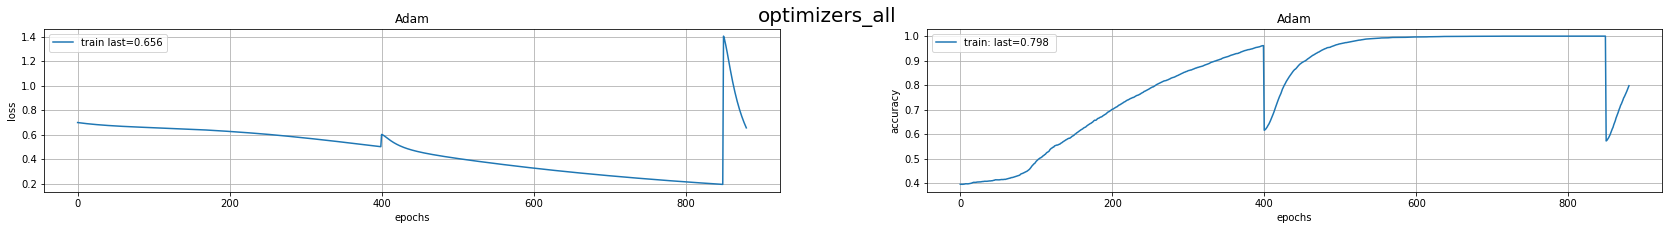

100%|██████████| 20/20 [00:00<00:00, 20.57it/s]


In [ ]:
configuration = optimizers_all
n_epochs = 20
n_epochs_plot = 10

train_model(configuration, X_train, y_train, X_test, y_test, suptitle='optimizers_all', n_epochs=n_epochs, n_epochs_plot=n_epochs_plot)

In [ ]:
# проверим точность после обучения

configuration = optimizers_all
configuration_key = 'Adam'

model = configuration[configuration_key]['model']
loss_function = configuration[configuration_key]['loss_train']

loss_val, correct_train = eval_model(model, X_test, y_test)
loss_val, correct_train

(tensor(0.5425, device='cuda:0'), tensor(0.8551, device='cuda:0'))

In [ ]:
# сохраним модели

configuration = optimizers_all
configuration_key = 'Adam'

file_name = f"model_{configuration_key}"
torch.save(configuration[configuration_key]['model'], file_name)



In [ ]:
configuration_key = 'Adam'
file_name = f"model_{configuration_key}"

model = torch.load(file_name)
loss_function = configuration[configuration_key]['loss_train']

bound = 10
n_grid = 100

verbose = False

alphas, betas, losses, accuraces = generate_surface(model_original=model, loss_function=loss_function, bound=bound, n_grid=n_grid, verbose=verbose)



bound: -10..10
grid: 10000 (100*100)
alphas: 100


100it [00:14,  7.12it/s]


In [ ]:

result = losses 
title = 'losses'

plot_surface(alphas=alphas, betas=betas, result=result, title=title)


In [ ]:
result = accuraces 
title = 'accuraces'

plot_surface(alphas=alphas, betas=betas, result=accuraces, title=title)

In [ ]:
configuration = optimizers_all
configuration_key = 'Adam'

model = configuration[configuration_key]['model']
loss_function = configuration[configuration_key]['loss_train']

loss_val, correct_train = eval_model(model, X_test, y_test)
loss_val, correct_train

(tensor(0.5425, device='cuda:0'), tensor(0.8551, device='cuda:0'))

In [ ]:
mid_channels_all[list(mid_channels_all.keys())[0]]['model']


CrossZeroNetConv(
  (model): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1))
    (5): Sigmoid()
  )
)

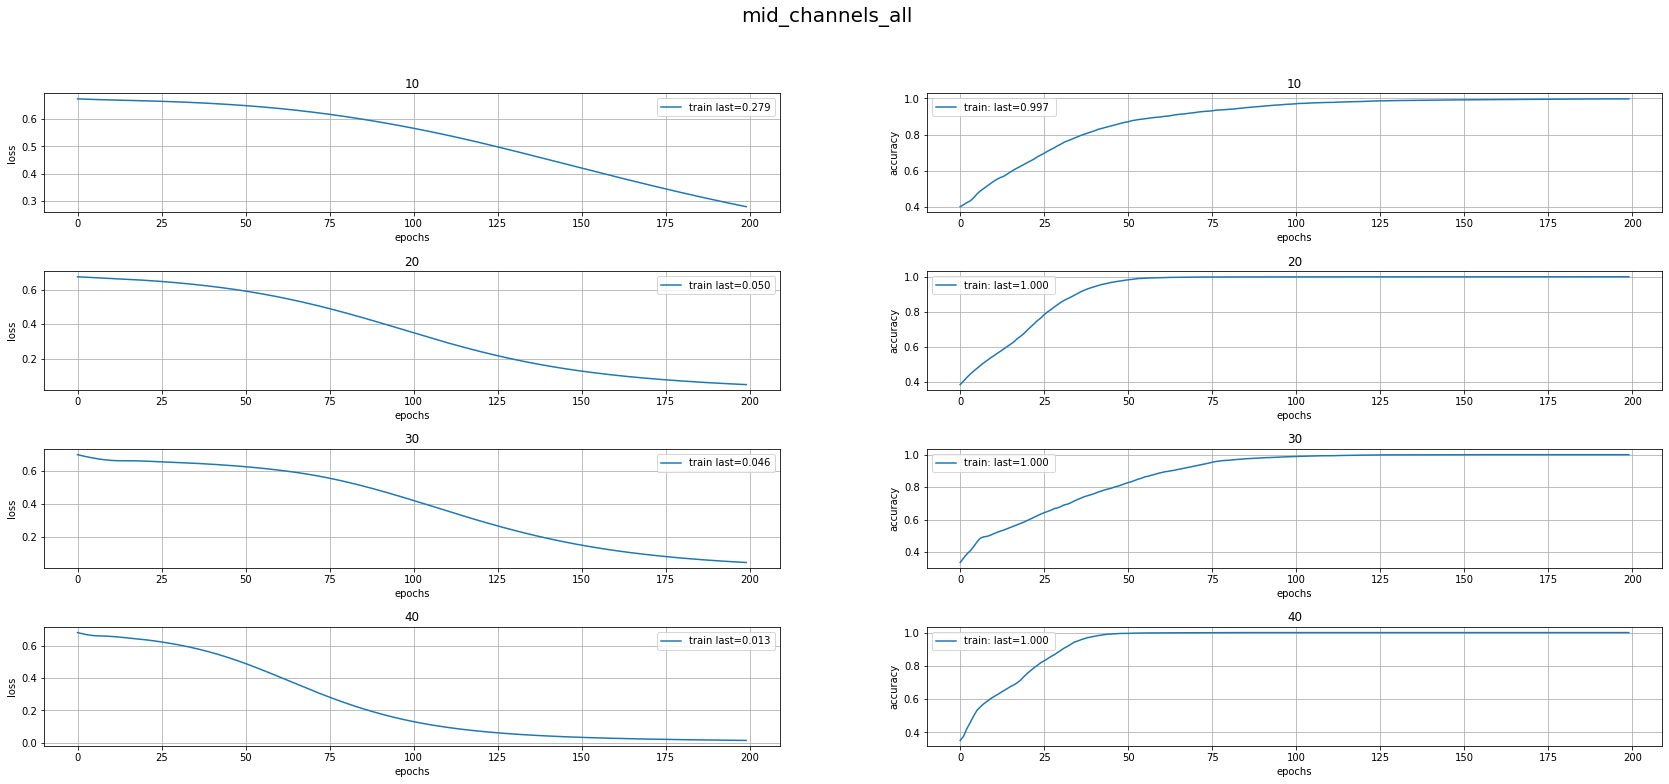

100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


In [ ]:
configuration = mid_channels_all
n_epochs = 100
n_epochs_plot = 1

train_model(configuration, X_train, y_train, X_test, y_test, suptitle='mid_channels_all', n_epochs=n_epochs, n_epochs_plot=n_epochs_plot)


In [ ]:
n_hidden_neurons_all[list(n_hidden_neurons_all.keys())[0]]['model']

CrossZeroNetDense(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=9, bias=True)
    (3): Sigmoid()
  )
)

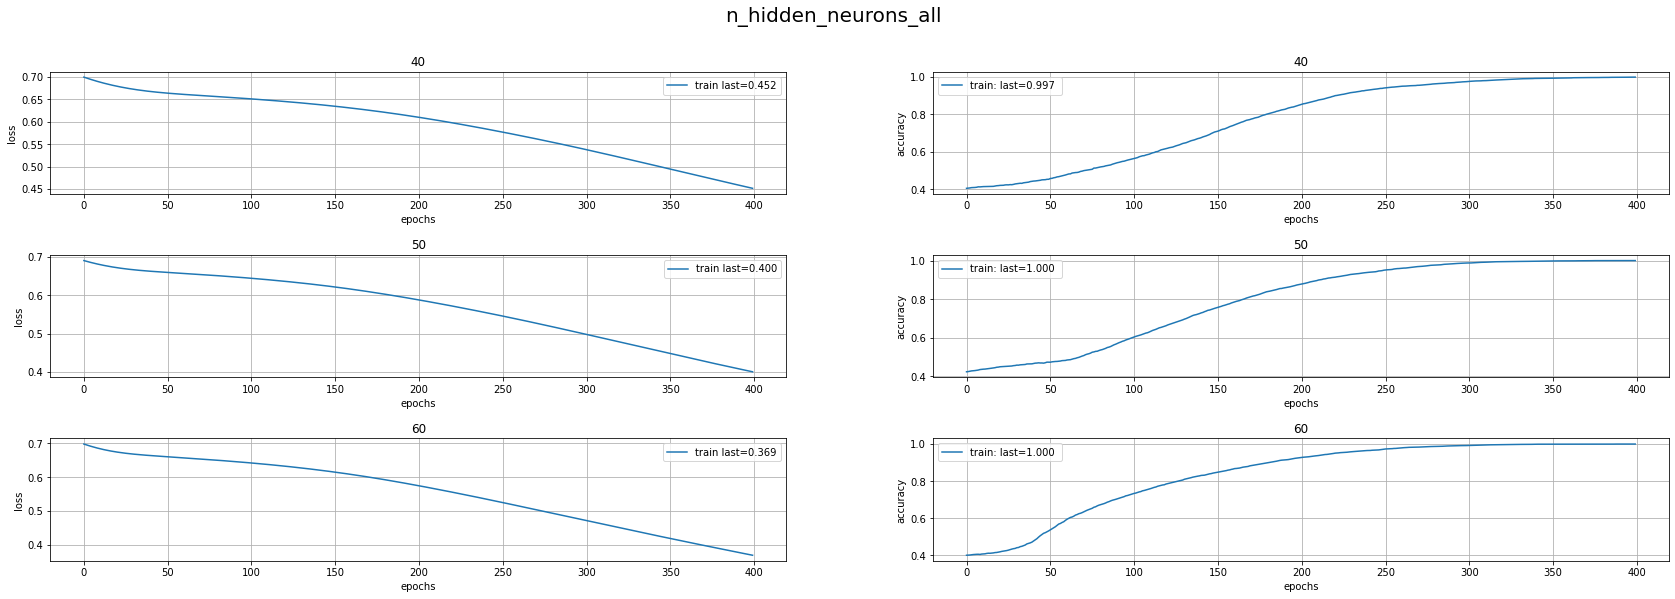

100%|██████████| 400/400 [08:09<00:00,  1.22s/it]


In [ ]:
configuration = n_hidden_neurons_all
n_epochs = 400
n_epochs_plot = 1

train_model(configuration, X_train, y_train, X_test, y_test, suptitle='n_hidden_neurons_all', n_epochs=n_epochs, n_epochs_plot=n_epochs_plot)


# сеть через эволюцию

## сеть
* вход: тензор 1*9, значения (-1, 0, 1), float
* скрытые слои: 
    * количество слоев - пока 1, попробовать динамическое добавление
    * количество нейронов - начинаем с 2, динамическое добавление
* выход: тензор 1*9, float, вероятности хода в соответствующую ячейку

In [ ]:
from Common import NetCurrent

In [ ]:
cross_zero_net = NetCurrent(hidden_count=2, verbose=True)
print(cross_zero_net)

Net: args=(), kwargs={}
NetCheck: args=(), kwargs={'hidden_count': 2, 'verbose': True}
NetMutate: args=(), kwargs={'hidden_count': 2, 'verbose': True}
NetCurrent(
  (hidden:linear): Linear(in_features=9, out_features=2, bias=True)
  (hidden:activation): ReLU()
  (output:linear): Linear(in_features=2, out_features=9, bias=True)
  (output:activation): Sigmoid()
)


In [ ]:
print(list(cross_zero_net.parameters()))

[Parameter containing:
tensor([[ 0.2678, -0.0267, -0.1805, -0.1647,  0.1560,  0.2630,  0.2029, -0.2148,
         -0.3301],
        [ 0.0925,  0.0357,  0.1816,  0.2527,  0.1698,  0.3298,  0.0866, -0.0053,
         -0.0660]], device='cuda:0'), Parameter containing:
tensor([0.2117, 0.0178], device='cuda:0'), Parameter containing:
tensor([[ 0.6659,  0.6549],
        [ 0.0359,  0.6342],
        [-0.0956, -0.5184],
        [-0.2713,  0.5872],
        [ 0.6731,  0.0062],
        [ 0.4608, -0.2355],
        [ 0.0231,  0.3093],
        [-0.5205, -0.3181],
        [ 0.5475, -0.5806]], device='cuda:0'), Parameter containing:
tensor([-0.1239,  0.6037,  0.4046,  0.5172, -0.2256,  0.4593,  0.2637, -0.5948,
         0.3147], device='cuda:0')]


In [ ]:
print(next(cross_zero_net.parameters()).device)

cuda:0


In [ ]:
input = torch.Tensor([
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
]).contiguous().view(-1).type(torch.float)
input.requires_grad = False
input = input.to(device)
print(input)

cross_zero_net.to(device)
output = cross_zero_net(input)
print(output)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
hidden.linear=tensor([0.2117, 0.0178], device='cuda:0')
hidden.activation=tensor([0.2117, 0.0178], device='cuda:0')
output.linear=tensor([ 0.0287,  0.6225,  0.3752,  0.4702, -0.0830,  0.5526,  0.2741, -0.7106,
         0.4203], device='cuda:0')
output.activation=tensor([0.5072, 0.6508, 0.5927, 0.6154, 0.4792, 0.6347, 0.5681, 0.3295, 0.6036],
       device='cuda:0')
tensor([0.5072, 0.6508, 0.5927, 0.6154, 0.4792, 0.6347, 0.5681, 0.3295, 0.6036],
       device='cuda:0')


## игрок
* вход: как у сети (тензор 1*9, float, значения (-1, 0, 1))
* выход: одно число, int - индекс ячейки в вытянутом тензоре 1*9

In [ ]:
from Common import PlayerRandom

In [ ]:
player = PlayerRandom()

input = torch.Tensor([
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
]).type(torch.float).contiguous().view(-1)
input.requires_grad = False
input = input.to(device)

output = player.make_move(input)
print(output)

2


In [ ]:
from Common import PlayerCurrent

In [ ]:
player = PlayerCurrent(NetCurrent)
print(player)

In [ ]:
input = torch.Tensor([
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
]).contiguous().view(-1)
input.requires_grad = False
input = input.to(device)

move = player.make_move(input)
print(move)

tensor(3, device='cuda:0')


In [ ]:
from Common import Presentation

## популяция

In [ ]:
from Common import PopulationCurrent

In [ ]:
population = PopulationCurrent(3)
print(population)

In [ ]:
from Common import PartyCurrent

In [ ]:
party = PartyCurrent(verbose=True)
print(party)

In [ ]:
player_our = PlayerCurrent()
player_enemy = PlayerRandom()

party_result = party.play_party(player_our, player_enemy)
print(party_result)



index_move=0
board:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')
player=<common.PlayerCurrent object at 0x7f6266a96550>
move=(0, 1)

index_move=1
board:
tensor([[0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')
player=<common.PlayerRandom object at 0x7f626963ec50>
move=(1, 2)

index_move=2
board:
tensor([[ 0.,  1.,  0.],
        [ 0.,  0., -1.],
        [ 0.,  0.,  0.]], device='cuda:0')
player=<common.PlayerCurrent object at 0x7f6266a96550>
move=(0, 1)
[{'points': tensor([1.], device='cuda:0'), 'win': False, 'invalid': True, 'invalid_enemy': False}, {'points': tensor([1.], device='cuda:0'), 'win': False, 'invalid': False, 'invalid_enemy': True}]


## вычисление результатов

In [ ]:
from Common import Scoring

In [ ]:
board = torch.Tensor([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
]).contiguous().view(-1).type(torch.float)
board = board.to(device)

print(Scoring.is_line(board, FIGURES_TO_VALUES['_X_']), Scoring.is_line(board, FIGURES_TO_VALUES['_0_']))


tensor(False) tensor(False)


In [ ]:
board = torch.Tensor([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
]).contiguous().view(-1).type(torch.float)
board = board.to(device)

print(Scoring.is_line(board, FIGURES_TO_VALUES['_X_']), Scoring.is_line(board, FIGURES_TO_VALUES['_0_']))


tensor(True) tensor(False)


In [ ]:
board = torch.Tensor([
    [-1, -1, -1],
    [-1, -1, -1],
    [-1, -1, -1],
]).contiguous().view(-1).type(torch.float)
board = board.to(device)

print(Scoring.is_line(board, FIGURES_TO_VALUES['_X_']), Scoring.is_line(board, FIGURES_TO_VALUES['_0_']))


tensor(False) tensor(True)


In [ ]:

FIGURES_TO_VALUES['_X_']


1

In [ ]:
Y_LEN

3

In [ ]:
for template in TEMPLATES_WIN:
    print(template)

[1 1 1 0 0 0 0 0 0]
[0 0 0 1 1 1 0 0 0]
[0 0 0 0 0 0 1 1 1]
[1 0 0 1 0 0 1 0 0]
[0 1 0 0 1 0 0 1 0]
[0 0 1 0 0 1 0 0 1]
[1 0 0 0 1 0 0 0 1]
[0 0 1 0 1 0 1 0 0]


In [ ]:
for template in TEMPLATES_WIN:
    print(Scoring.is_line(torch.Tensor(template).to(device), FIGURES_TO_VALUES['_X_']))
    # board = template
    # figure_value = FIGURES_TO_VALUES['_X_']
    # win_len = Y_LEN
    # print(np.any([(np.abs((template * (board == figure_value)).sum()) >= abs(win_len * figure_value)) for template in
    #         TEMPLATES_WIN]))


tensor(True)
tensor(True)
tensor(False)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)


In [ ]:
for template in TEMPLATES_WIN:
    # print(template.device)
    print(Scoring.is_line(torch.Tensor(template).to(device), FIGURES_TO_VALUES['_0_']))
    # figure_value = FIGURES_TO_VALUES['_X_']
    # win_len = Y_LEN
    # print(any([((template * (board == figure_value)).sum().abs() >= abs(win_len * figure_value)) for template in
    #         TEMPLATES_WIN]))


tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


In [ ]:
from Common import EvaluatePlayerCurrent

In [ ]:
evaluate_player = EvaluatePlayerCurrent(num_parties=10
                                        # PARTIES['random']
                                        )
print(evaluate_player)

In [ ]:
# evaluate_player.party.verbose = False

In [ ]:
player = PlayerCurrent()
print(player)

In [ ]:
result = evaluate_player.evaluate(player)
print(result)

tensor([1.7000], device='cuda:0')


In [ ]:
from Common import EvaluatePopulationCurrent


In [ ]:
evaluate_population = EvaluatePopulationCurrent(num_parties=100)
print(evaluate_population)

In [ ]:
population = PopulationCurrent(10)
print(population)

In [ ]:
print(population.players)

In [ ]:
evaluate_population.evaluate(population)
print([p.score for p in population.players])

[tensor([1.], device='cuda:0'), tensor([1.], device='cuda:0'), tensor([1.], device='cuda:0'), tensor([1.], device='cuda:0'), tensor([1.], device='cuda:0'), tensor([1.], device='cuda:0'), tensor([1.2900], device='cuda:0'), tensor([1.1500], device='cuda:0'), tensor([1.2800], device='cuda:0'), tensor([1.7400], device='cuda:0')]


## тренировка

In [ ]:
from Common import TrainPopulationCurrent

In [ ]:
train_population = TrainPopulationCurrent(num_parties=10, evaluate_population_class=EvaluatePopulationCurrent, num_epoch=20)
print(train_population)

In [ ]:
population = PopulationCurrent(20, hidden_count=30)
print(population)

In [ ]:
print(train_population.train(population))

index_epoch=0
top 10 = ['2.00 (len=30, max=0.33)', '1.70 (len=30, max=0.33)', '1.60 (len=30, max=0.33)', '1.60 (len=30, max=0.33)', '1.50 (len=30, max=0.33)', '1.50 (len=30, max=0.33)', '1.50 (len=30, max=0.33)', '1.50 (len=30, max=0.33)', '1.40 (len=30, max=0.33)', '1.30 (len=30, max=0.33)']
index_epoch=1
top 10 = ['2.30 (len=30, max=0.33)', '2.30 (len=30, max=0.47)', '2.30 (len=30, max=0.33)', '2.20 (len=30, max=0.33)', '2.20 (len=30, max=0.33)', '2.20 (len=30, max=0.34)', '2.10 (len=30, max=0.44)', '2.00 (len=30, max=0.34)', '2.00 (len=30, max=0.33)', '2.00 (len=30, max=0.33)']
index_epoch=2
top 10 = ['2.50 (len=30, max=0.47)', '2.50 (len=30, max=0.47)', '2.40 (len=30, max=0.47)', '2.20 (len=30, max=0.47)', '2.10 (len=30, max=0.41)', '2.00 (len=30, max=0.46)', '2.00 (len=30, max=0.47)', '1.90 (len=30, max=0.33)', '1.80 (len=30, max=0.46)', '1.80 (len=30, max=0.46)']
index_epoch=3
top 10 = ['2.80 (len=30, max=0.49)', '2.50 (len=30, max=0.47)', '2.40 (len=30, max=0.47)', '2.40 (len=30

In [ ]:
population.players[0].net

NetCurrent(
  (hidden:linear): Linear(in_features=9, out_features=30, bias=True)
  (hidden:activation): ReLU()
  (output:linear): Linear(in_features=30, out_features=9, bias=True)
  (output:activation): Sigmoid()
)

In [ ]:
model = population.players[0].net
model.to(device)
model

NetCurrent(
  (hidden:linear): Linear(in_features=9, out_features=30, bias=True)
  (hidden:activation): ReLU()
  (output:linear): Linear(in_features=30, out_features=9, bias=True)
  (output:activation): Sigmoid()
)

In [ ]:
loss_function = torch.nn.BCELoss()
loss_function

BCELoss()

In [ ]:
X_test_reshape = X_test.reshape(X_test.shape[0], -1)
# .reshape(x.shape[0], 1, Y_LEN, X_LEN)
X_test_reshape.shape

torch.Size([6617, 9])

In [ ]:
result = model(X_test_reshape)
result.shape

torch.Size([6617, 9])

In [ ]:
y_test.shape

torch.Size([6617, 1, 3, 3])

In [ ]:
# проверим точность после обучения

model.train(False)

loss_val, correct_train = eval_model(model, loss_function, X_test, y_test, verbose=True)
loss_val, correct_train

X_test:torch.Size([6617, 1, 3, 3])
X_test_reshape:torch.Size([6617, 9])
pred:torch.Size([6617, 9])
pred:torch.Size([6617, 1, 3, 3]), <class 'torch.Tensor'>, torch.float32
y_test:torch.Size([6617, 1, 3, 3]), <class 'torch.Tensor'>, torch.float32


(tensor(0.7007, device='cuda:0'), tensor(0.4031, device='cuda:0'))

In [ ]:
# сохраним модели
configuration_key = 'population.players[0].net'

file_name = f"model_{configuration_key}"
torch.save(population.players[0].net, file_name)



In [ ]:
configuration_key = 'population.players[0].net'
file_name = f"model_{configuration_key}"

model = torch.load(file_name)
loss_function = torch.nn.BCELoss()

bound = 10
n_grid = 100

verbose = False

alphas, betas, losses, accuraces = generate_surface(model_original=model, loss_function=loss_function, bound=bound, n_grid=n_grid, verbose=verbose)



bound: -10..10
grid: 10000 (100*100)
alphas: 100


100it [00:13,  7.21it/s]


In [ ]:

result = losses 
title = 'losses'

plot_surface(alphas=alphas, betas=betas, result=result, title=title)


In [ ]:
result = accuraces 
title = 'accuraces'

plot_surface(alphas=alphas, betas=betas, result=accuraces, title=title)

In [ ]:
loss_val, correct_train = eval_model(model, loss_function, X_test, y_test, verbose=True)
loss_val, correct_train

TypeError: ignored

# Выводы:
* до конца все равно не разобрался, 
* но построил примерные графики поверхностей функций потерь и точности
* и они натолкнули на некоторые мысли



## ниже - повтор графиков с объяснениями


## конфигурация сети - во всех экспериментах одинаковая
* один скрытый полносвязный слой, 30 нейронов, активация RELU
* выходной полносвязный слой, 9 нейронов, активация сигмоида

### сеть с back-propagation
* тестовая и валидационная выборка - 6 тысяч комбинаций, для каждой посчитаны допустимые и недопустимые ходы
* лосс-функция - бинарная кросс-энтропия
* метрика - точность (ход с максимальной вероятностью должен совпадать с допустимым ходом для каждой комбинации из выборки)
* сеть училась около 100 эпох, точность поднялась почти до 100%

### график 1.1
* поверхность лосс-функции
* видно, что поверхность гладкая, явно выраженный минимум в середине

In [ ]:

result = losses 
title = 'losses'

plot_surface(alphas=alphas, betas=betas, result=result, title=title)


### график 1.2
* поверхность метрики (точность) 
* видно, что поверхность ребристая, совсем не гладная и не выпулкая
* есть явно выраженный максимум в середине
* при этом есть небольшие локальные пики максимумов
* и что совсем странно
    * явный провал в непосредственной близости от нуля, в области отрицательных координат, 
    * повторяется всегда при разных рандомных генерациях начальных векторов
    * причина непонятна

In [ ]:
result = accuraces 
title = 'accuraces'

plot_surface(alphas=alphas, betas=betas, result=accuraces, title=title)

### сеть с эволюцией
* тестовой выборки нет
* оценка каждого экземпляра популяции
    * играется 10 партий со случайным игроком
    * считается среднее количество правильно сделанных ходов (максимум 5) 
* валидационная выборка - такая же, как раньше
* лосс-функция - такая же, как раньше (бинарная кросс-энтропия)
* метрика - такая же, как раньше (точность)
    * это не совсем правильно, так как надо считать по той же метрике, что использовалась при отборе популяции
* популяция училась около 20 эпох, средний результат 3.0 правильных хода за партию

### график 2.1
* поверхность лосс-функции
* как и в прошлый раз - видно, что поверхность гладкая, явно выраженный минимум в середине

In [ ]:

result = losses 
title = 'losses'

plot_surface(alphas=alphas, betas=betas, result=result, title=title)


### график 2.2
* поверхность метрики (точность)
* а вот тут проблемы
    * поверхность сильно изрезанная, со множеством острых локальных максимумов
    * предполагаю, что если сделать поверхность поверхность функции отбора популяции - то будет так же или еще хуже
    * поэтому генетическое блуждание по такой поверхности и не приводит к глобальному максимуму

In [ ]:
result = accuraces 
title = 'accuraces'

plot_surface(alphas=alphas, betas=betas, result=accuraces, title=title)